# Goldman equation

The transmembrane potential of a semipermeable membrane is dependent on the concentration [X] and permitivity $g_X$ of ions.
When more than one ion species is considered around a semipermeable membrane the equilibrium potential is given by the Goldmann equation. Considering Sodium and Potassium, the Goldmann eq. is:

$$
V_m ={\frac  {RT}{F}}\ln {\left({\frac  {g_{{{\text{Na}}}}[{\text{Na}}^{{+}}]_{{\mathrm  {out}}}+g_{{{\text{K}}}}[{\text{K}}^{{+}}]_{{\mathrm  {out}}}}{g_{{{\text{Na}}}}[{\text{Na}}^{{+}}]_{{\mathrm  {in}}}+g_{{{\text{K}}}}[{\text{K}}^{{+}}]_{{{\mathrm  {in}}}}}}\right)}
$$
$$
%V_m ={\frac  {RT}{F}}\ln {\left({\frac  {P_{{{\text{Na}}}}[{\text{Na}}^{{+}}]_{{\mathrm  {out}}}+P_{{{\text{K}}}}[{\text{K}}^{{+}}]_{{\mathrm  {out}}}+P_{{{\text{Cl}}}}[{\text{Cl}}^{{-}}]_{{\mathrm  {in}}}}{P_{{{\text{Na}}}}[{\text{Na}}^{{+}}]_{{\mathrm  {in}}}+P_{{{\text{K}}}}[{\text{K}}^{{+}}]_{{{\mathrm  {in}}}}+P_{{{\text{Cl}}}}[{\text{Cl}}^{{-}}]_{{\mathrm  {out}}}}}\right)}
$$

First, the Goldman eq. is defined in python code.
- Run the following code by selecting (click on it) and then pressing SHIFT+ENTER or CTRL+ENTER

## Effect of opening channels

In [30]:
from brian2 import *
from matplotlib import pyplot as plt
%matplotlib notebook

In [31]:
g_Na_standard = 0.05
g_K_standard = 1.0
Na_in_standard = 15
Na_out_standard = 145
K_in_standard = 140
K_out_standard = 4

def vm_goldmann(g_Na=g_Na_standard,
                g_K=g_K_standard,
                Na_in=Na_in_standard,
                Na_out=Na_out_standard,
                K_in=K_in_standard,
                K_out=K_out_standard):
    """The Goldman-Hodgkin-Katz equation.
       input: Conductivities and concentrations in arbitrary units.
       returns: Vm in volt."""

    # RT/F at room temperature
    prefactor = 26.7e-3  # Volt

    # the conductivity weighted concentration ratio sum
    gc_ratio = (g_Na*Na_out + g_K * K_out)/(g_Na*Na_in + g_K * K_in)

    # Return the transmembrane potential
    vm = prefactor * np.log(gc_ratio)
    return vm

<IPython.core.display.Javascript object>


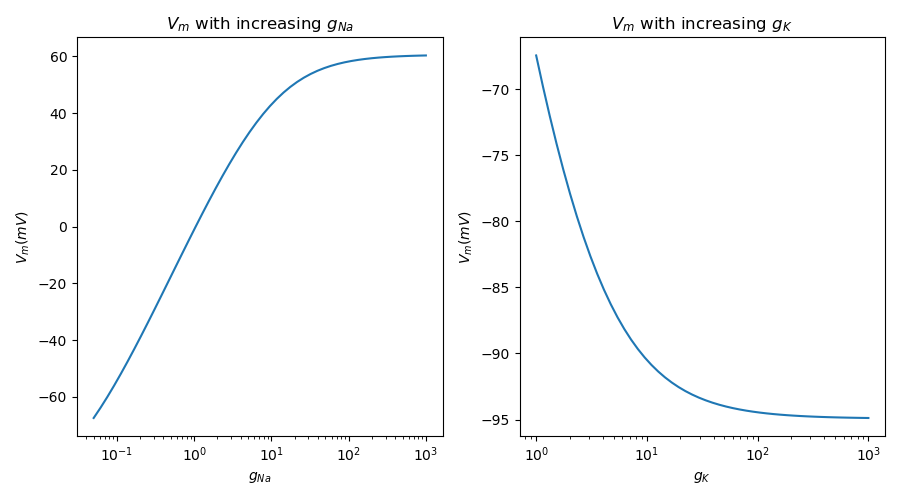

In [32]:
g_Na_list = np.logspace(np.log10(0.05), 3)
fig, axs = plt.subplots(1, 2, figsize=(9, 5))
axs[0].plot(g_Na_list, 1e3*vm_goldmann(g_Na=g_Na_list))
axs[0].semilogx()
axs[0].set_ylabel("$V_m (mV)$")
axs[0].set_title("$V_m$ with increasing $g_{Na}$")
axs[0].set_xlabel("$g_{Na}$")

g_K_list = np.logspace(np.log10(1), 3)
axs[1].plot(g_K_list, 1e3*vm_goldmann(g_K=g_K_list))
axs[1].semilogx()
axs[1].set_ylabel("$V_m (mV)$")
axs[1].set_title("$V_m$ with increasing $g_{K}$")
axs[1].set_xlabel("$g_{K}$")
fig.tight_layout()
# axs[1].set_xlim(axs[1].get_xlim()[::-1])

<IPython.core.display.Javascript object>


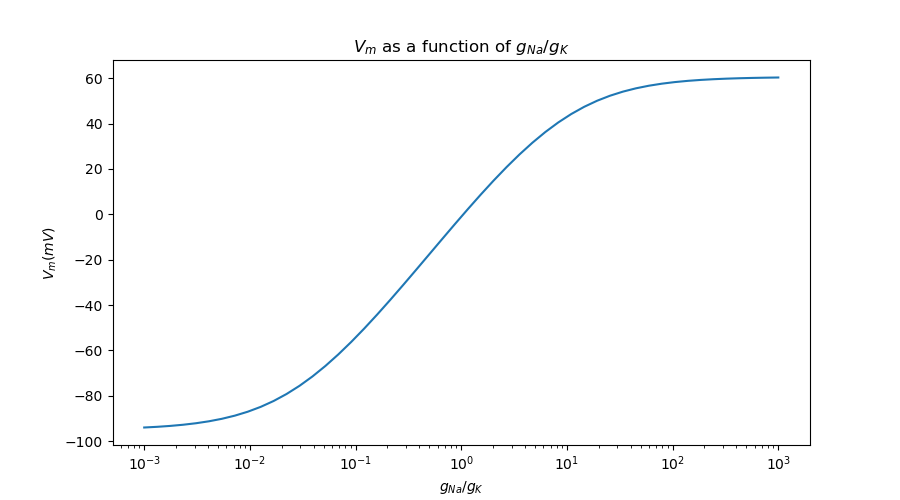

In [33]:
g_Na_list = np.logspace(-3, 3)
g_ratio_list = g_Na_list/g_K_standard
fig, ax = plt.subplots(1,1,figsize=(9,5))
ax.plot(g_ratio_list, 1e3*vm_goldmann(g_Na=g_ratio_list))
ax.semilogx()
ax.set_ylabel("$V_m (mV)$")
ax.set_title("$V_m$ as a function of $g_{Na} / g_K$")
ax.set_xlabel("$g_{Na}/g_K$");

# Current injection at passive Cable

What happens when current is injected in a thin nerve fiber, how does the current spread?


The answer is given by the core-conductor- or cable-model. 
It is a very general model that can be dated back to Lord Kelvin who derived it to describe transatlatic communication cables. Bioelectricity, e.g. in nerve fibers, obeys the same physical laws.
(More generally speaking the cable equation is the one dimensional heat equation. So you can think of a thin metal rod that is heated at one point, how does the heat spread?).

In this model the ion species are not distinguished, there is just one current (of course still with a capacitive and a resistive component). We use a library called Brian to numerically solve the equations.
- The capacitive current is calculated inside of Brian. You just define the specific capacity Cm, and the geometry.
- The resistive current is given by $$ I_m = g_L \cdot (E_L - V_m) $$ 

The following code inject current at one end of a finite (not infinite) passive fiber. 
You may change capacity, Radius, current injection amplitude, leakynes .... 

- Run the following code by selecting (click on it) and then pressing SHIFT+ENTER or CTRL+ENTER

Electrotonic length: 0.41 mm


<IPython.core.display.Javascript object>


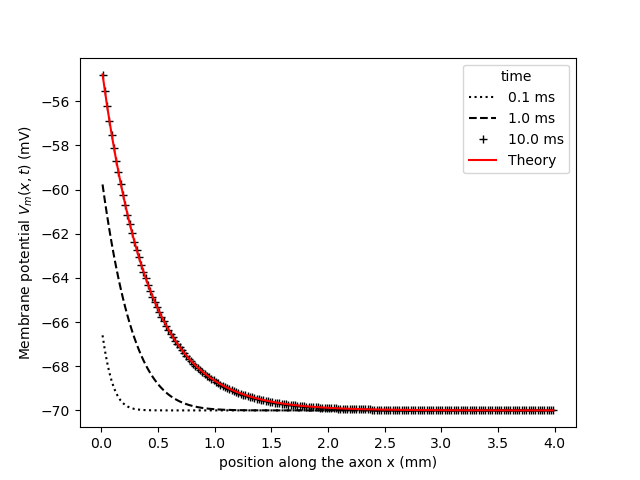

Starting simulation at t=0. s for a duration of 0.5 ms
0.5 ms (100%) simulated in < 1s
Starting simulation at t=0.5 ms for a duration of 4.5 ms
4.5 ms (100%) simulated in < 1s
Starting simulation at t=5. ms for a duration of 45. ms
45. ms (100%) simulated in < 1s


In [52]:
start_scope()
defaultclock.dt = 0.1*ms

# Morphology
diameter = 1*um
length = 4*mm
Cm = 1*uF/cm**2
Ri = 150*ohm*cm
N = 200
morpho = Cylinder(diameter=diameter, length=length, n=N)

# Passive channels
gL = 1e-4*siemens/cm**2
EL = -70*mV
eqs = '''
Im = gL * (EL - v) : amp/meter**2
I : amp (point current)
'''

neuron = SpatialNeuron(morphology=morpho, model=eqs, Cm=Cm, Ri=Ri,
                       method='exponential_euler')
neuron.v = EL
M = StateMonitor(neuron, 'v', record=[0, 10, 50, 100])

la = neuron.space_constant[0]
print("Electrotonic length: %s" % la.in_best_unit(2))


# Currrent injection at one end
neuron.I[0] = 0.02*nA 

# Running an plotting
plt.figure()
run(.5*ms, report='text')
plot(neuron.distance/mm, neuron.v/mV, 'k:', label="0.1 ms")
run(4.5*ms, report='text')
plot(neuron.distance/mm, neuron.v/mV, 'k--', label="1.0 ms")
run(45*ms, report='text')
plot(neuron.distance/mm, neuron.v/mV, 'k+', label="10.0 ms")
# Plot theory
x = neuron.distance
ra = la * 4 * Ri / (pi * diameter**2)
theory = EL + ra * neuron.I[0] * cosh((length - x) / la) / sinh(length / la)
plot(x/mm, theory/mV, 'r', label=r"Theory")

xlabel('position along the axon x (mm)')
ylabel('Membrane potential $V_m(x, t)$ (mV)')
legend(title="time")

<IPython.core.display.Javascript object>


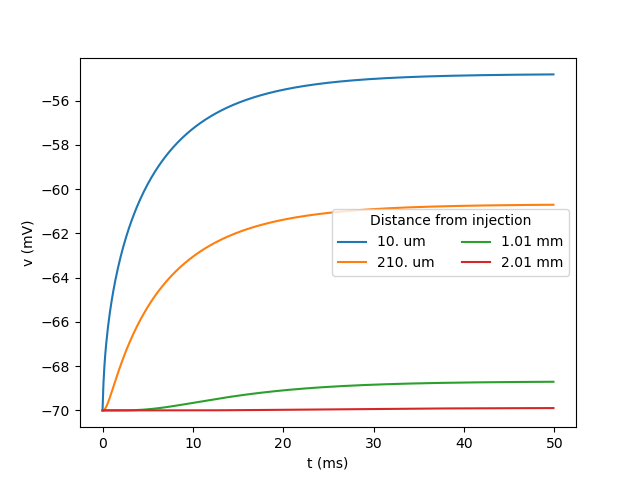

Text(0, 0.5, 'v (mV)')

In [45]:
plt.figure()
plot(M.t/ms, M.v.T/mV)
legend(title="Distance from injection", loc="best", ncol=2, labels=x[M.record])
xlabel('t (ms)')
ylabel('v (mV)')

# HH Action Potential

An AP is a rapid and propagating jump in the transmembrane potential. There are many models to describe such a process.
The most famous one is the HH model, which is a very detailed purely electrical model.
In the first Section it was found that a change in ion specific permeabilities effects the membrane potential. 

The HH model uses the Goldman eq. and describes the permeabilities with 
voltage and time dependent expressions.
It has more than 20 constant parameters and 3 internal variables (m, n, h).
With so many parameters, various AP shapes can be reproduced.
However, these properties can not be monitored or controlled so easily, and it is not reaally clear what m, n and h represent in an actual neuron.


The following code simuates a HH AP along a long axon, and calculates the propagation velocity.

- Run the following code by selecting (click on it) and then pressing SHIFT+ENTER or CTRL+ENTER
  (If it doesnt work you can also try at https://mybinder.org/v2/gh/brian-team/brian2-binder/master?filepath=examples/compartmental/hh_with_spikes.ipynb)
- whats the AP velocity?

The nerve is almost half a millimeter thick and still the AP speed is rather disenchanting (should be around 12 m/s)
You have heard of myelin which wraps around axons and increases the AP propagation speed.
We can include the insulating effect of myelin by decreasing the leak condictivity $g_L$.
(Note, divide $g_L$ by 2 would double the so called Electrotonic length or "length parameter")

- Try to make the AP double its speed by decresing $g_L$.
  What is the relation between length parameter and propagation speed?

- Change $C_m$ to reach the desired velocity.

- Bonus for fun: Are there other ways to accelerate the AP?

In [61]:
from scipy import stats

start_scope()
defaultclock.dt = 0.05*ms

morpho = Cylinder(length=10*cm, diameter=2*238*um, n=1000)

El = 10.613*mV
ENa = 115*mV
EK = -12*mV
gl = 0.4*msiemens/cm**2
gNa0 = 120*msiemens/cm**2
gK = 36*msiemens/cm**2

# HH equations
eqs = '''
Im = gl * (El-v) + gNa * m**3 * h * (ENa-v) + gK * n**4 * (EK-v) : amp/meter**2
I : amp (point current) # applied current
dm/dt = alpham * (1-m) - betam * m : 1
dn/dt = alphan * (1-n) - betan * n : 1
dh/dt = alphah * (1-h) - betah * h : 1
alpham = (0.1/mV) * 10.0*mV/exprel((-v+25.0*mV)/(10.0*mV))/ms : Hz
betam = 4 * exp(-v/(18.0*mV))/ms : Hz
alphah = 0.07 * exp(-v/(20.0*mV))/ms : Hz
betah = 1/(exp((-v+30.0*mV) / (10.0*mV)) + 1)/ms : Hz
alphan = (0.01/mV) * 10.0*mV/exprel((-v+10.0*mV)/(10.0*mV))/ms : Hz
betan = 0.125*exp(-v/(80.0*mV))/ms : Hz
gNa : siemens/meter**2
'''

neuron = SpatialNeuron(morphology=morpho, model=eqs, method="exponential_euler",
                       refractory="m > 0.4", threshold="m > 0.5",
                       Cm=1*uF/cm**2, Ri=35.4*ohm*cm)
neuron.v = 0*mV
neuron.h = 1
neuron.m = 0
neuron.n = .5
neuron.I = 0*amp
neuron.gNa = gNa0
M = StateMonitor(neuron, 'v', record=True)
spikes = SpikeMonitor(neuron)


la = neuron.space_constant[0]
print("Electrotonic length: %s" % la.in_best_unit(2))
print("Passive membrane time (Theory):", Cm/gl)
print('------------------- Running ---------------------')

run(50*ms, report='text')
neuron.I[0] = 1*uA # current injection at one end
run(3*ms)
neuron.I = 0*amp
run(50*ms, report='text')

Electrotonic length: 3.56 mm
Passive membrane time (Theory): 2.5 ms
------------------- Running ---------------------
Starting simulation at t=0. s for a duration of 50. ms
50. ms (100%) simulated in < 1s
Starting simulation at t=53. ms for a duration of 50. ms
50. ms (100%) simulated in < 1s


Velocity = 11.85 m/s


<IPython.core.display.Javascript object>


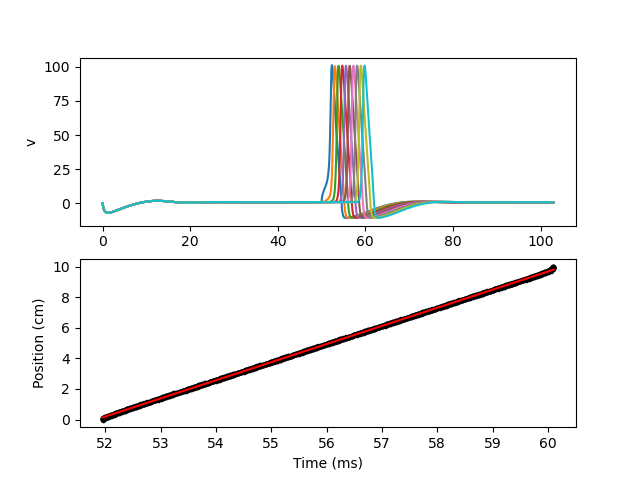

In [62]:
# Calculation of velocity
slope, intercept, r_value, p_value, std_err = stats.linregress(spikes.t/second,
                                                neuron.distance[spikes.i]/meter)
print("Velocity = %.2f m/s" % slope)
plt.figure()
subplot(211)
for i in range(10):
    plot(M.t/ms, M.v.T[:, i*100]/mV)
ylabel('v')
subplot(212)
plot(spikes.t/ms, spikes.i*neuron.length[0]/cm, '.k')
plot(spikes.t/ms, (intercept+slope*(spikes.t/second))/cm, 'r')
xlabel('Time (ms)')
ylabel('Position (cm)')
show()